Librerias

In [1]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time

Decorador tiempo de ejecución

In [22]:
def count_elapsed_time(f):
    """
    Decorator.
    Execute the function and calculate the elapsed time.
    Print the result to the standard output.
    """
    def wrapper():
        # Start counting.
        start_time = time()
        # Take the original function's return value.
        ret = f()
        # Calculate the elapsed time.
        elapsed_time = time() - start_time
        print("Elapsed time: %0.10f seconds." % elapsed_time)
        return ret
    
    return wrapper

Primera Entrega - Proyecto MRI

In [6]:
data_dir = 'MRIsamples/'
data_dir_save = data_dir + 'analyze_to_nii/'
data_ext = ['.img', '.hdr', '.nii']
filenames = ['4_8', '8_4', '100_23', '205_3']

In [9]:
for filename in filenames:
    try:
        #Se carga la imagen MRI simple en formato ANALYZE
        path = data_dir + filename
        img = nb.load(path + data_ext[0])
        hdr = nb.load(path + data_ext[1])

        #Se muestra la información del encabezado
        print(f"Archivo: '{filename}'")
        print(hdr.header)
        print('*********************************************************************')
        
        #Se convierte el formato de ANALYZE a NIFTI
        nii = nb.nifti1.Nifti1Image(img.get_fdata(), 
                                    hdr.affine, 
                                    hdr.header)

        #Se guarda la imagen MRI simple en formato NIFTI
        path = path.replace(data_dir, data_dir_save) + data_ext[2]
        nb.save(nii, path)
    except FileNotFoundError:
        print(f"No se pudo cargar el archivo: '{filename}'")
        print('*********************************************************************')
    except AttributeError:
        print(f"El archivo: '{filename}', se encuentra vacio")
        print('*********************************************************************')

Archivo: '4_8'
<class 'nibabel.spm2analyze.Spm2AnalyzeHeader'> object, endian='<'
sizeof_hdr     : 348
data_type      : b'dsr      '
db_name        : b'..\\work_t1\\ibsr\\o'
extents        : 0
session_error  : 0
regular        : b'r'
hkey_un0       : b'0'
dim            : [  4 256  61 256   1   0   0   0]
vox_units      : b'mm'
cal_units      : b''
unused1        : 0
datatype       : int16
bitpix         : 16
dim_un0        : 0
pixdim         : [0.  1.  3.1 1.  0.  0.  0.  0. ]
vox_offset     : 0.0
scl_slope      : nan
scl_inter      : 0.0
funused3       : 0.0
cal_max        : 0.0
cal_min        : 0.0
compressed     : 0
verified       : 0
glmax          : 32767
glmin          : 0
descrip        : b'spm compatible'
aux_file       : b'none                   '
orient         : b''
origin         : [91 34 91  0  0]
generated      : b''
scannum        : b''
patient_id     : b''
exp_date       : b''
exp_time       : b''
hist_un0       : b''
views          : 0
vols_added     : 0
start_field  

Segunda Entrega - Proyecto MRI

(138, 55)


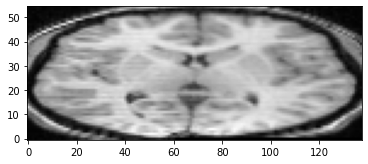

In [356]:
path = data_dir_save + 'filename' + data_ext[2]

#Se cargan las imagenes en formato NIFTI
img_4_8 = nb.load(path.replace('filename', filenames[0]))
img_8_4 = nb.load(path.replace('filename', filenames[1]))
img_100_23 = nb.load(path.replace('filename', filenames[2]))
img_205_3 = nb.load(path.replace('filename', filenames[3]))

#se extrae un corte de la imagen sagital
img1 = img_4_8.get_fdata()
img1 = img1[150,:,:][:,:,0]
img1 = img1[0:58,92:210]

#se extrae un corte de la imagen coronal 
img2 = img_8_4.get_fdata()
img2 = img2[:,20,:][:,:,0]
img2 = img2[72:193,76:191]

#se extrae un corte de la imagen axial 
img3 = img_100_23.get_fdata()
img3 = img3[:, : ,157][:,:,0]
img3 = img3[58:196, 0:55]

print(img3.shape)

plt.imshow(img3.T, origin='lower', cmap='gray')
plt.show()

Difusión Anisotrópica - Explicita

In [14]:
def anisotropic_diffusion(img, v=1, k=0.6):
    t = -1/4#1 / (1 + (2 * v + 1))
    i = j = v
    
    convolvedImg = np.zeros((img.shape[0], img.shape[1]))

    for f in range(convolvedImg.shape[0]):
        for c in range(convolvedImg.shape[1]):
            mat = mask(img, f, c, v)
            
            #mgfe = mod_grad_f(mat, j, i + 1, 'fe')
            #cfe = diff_coef(mgfe, k)
            #fe = cfe * (mat[j, i + 1] - mat[j, i])
            
            #mgfw = mod_grad_f(mat, j, i - 1, 'fw')
            #cfw = diff_coef(mgfw, k)
            #fw = cfw * (mat[j, i] - mat[j, i - 1])
            
            #mgfs = mod_grad_f(mat, j + 1, i, 'fs')
            #cfs = diff_coef(mgfs, k)
            #fs = cfs * (mat[j + 1, i] - mat[j, i])
            
            #mgfn = mod_grad_f(mat, j - 1, i, 'fn')
            #cfn = diff_coef(mgfn, k)
            #fn = cfn * (mat[j, i] - mat[j - 1, i])
  
            convolvedImg[f, c] = t * (mat[j, i + 1] + mat[j, i - 1] + mat[j + 1, i] + mat[j - 1, i])#(fe - fw + fs - fn)
    
    return convolvedImg

def mask(img, j, i, v):
    n = 2 * v + 1
    mat = np.full((n, n), -1)
    
    jmin = (j - v, 0)[(j - v) < 0]
    jmax = (jmin + n, jmin + (n - 1))[(j + v) == img.shape[0] or (j - v) < 0]
    
    imin = (i - v, 0)[(i - v) < 0]
    imax = (imin + n, imin + (n - 1))[(i + v) == img.shape[1] or (i - v) < 0]
    
    f = (0, 1)[(j - v) < 0]
    c1 = (0, 1)[(i - v) < 0]
    
    for j in range(jmin, jmax):
        c = c1
        
        for i in range(imin, imax):
            mat[f, c] = img[j, i]
            c += 1
            
        f += 1
            
    return mat

def mod_grad_f(img, j, i, f):
    mgf = 0

    if(f == 'fe'):#1,2
        mgf = pow(img[j, i] - img[j, i - 1], 2) + pow((img[j + 1, i] - img[j - 1, i]) / 2, 2)
    elif(f == 'fw'):#1,0
        mgf = pow(img[j, i + 1] - img[j, i], 2)#pow(img[j, i + 1] - img[j, i], 2) + pow((img[j + 1, i] - img[j - 1, i]) / 2, 2) 
    elif(f == 'fs'):#2,1
        mgf = pow(img[j, i] - img[j - 1, i], 2)#pow((img[j, i + 1] - img[j, i - 1]) / 2, 2) + pow(img[j, i] - img[j - 1, i], 2)
    else:#'fn':0,1
        mgf = pow(img[j + 1, i] - img[j, i], 2)#pow((img[j, i + 1] - img[j, i - 1]) / 2, 2) + pow(img[j + 1, i] - img[j, i], 2)
    
    return np.sqrt(mgf)

def diff_coef(mgf, k):
    return np.exp(-pow(mgf / k, 2))

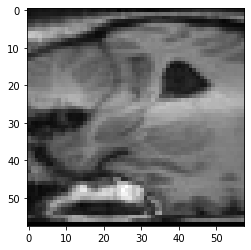

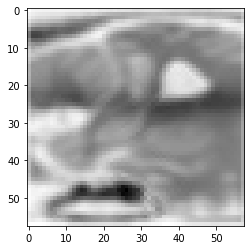

In [15]:
#plt.figure(figsize=(4,4))
plt.imshow(img1, cmap='gray')
plt.show()

im1 = anisotropic_diffusion(img1)

plt.imshow(im1, cmap='gray')
plt.show()

#plt.imshow(anisotropic_diffusion(img1, 1, 0.6), cmap='gray')
#plt.show()

#plt.imshow(anisotropic_diffusion(img1, 1, 1), cmap='gray')
#plt.show()

#plt.imshow(anisotropic_diffusion(img1, 1, 2), cmap='gray')
#plt.show()

#plt.imshow(anisotropic_diffusion(img1, 1, 3), cmap='gray')
#plt.show()

In [32]:
def x_to_img(h, w, x):
    i = j = 0
    
    img = np.zeros((h, w))
    
    for f in range(x.shape[0]):
        img[j, i] = x[f, 0]
        i = i + 1
        
        if i == w:
            i = 0
            j = j + 1
    
    return img

In [236]:
def create_A_x_b(img):
    m = img.shape[0] * img.shape[1]
    A = np.identity(m)
    x = np.array([img.flatten()]).T
    b = np.zeros((m , 1))
    i = 1
    
    for f in range(m - 1):
        c1 = f + 1
        c2 = f + img.shape[1]
        
        if(i < img.shape[1]):
            A[f, c1] = -1/4
            A[c1, f] = -1/4
            
            if(c2 < m):
                A[f, c2] = -1/4
                A[c2, f] = -1/4
            
            i += 1
        else:
            A[f, c2] = -1/4
            A[c2, f] = -1/4
            i = 1
    
    return A,x,b

In [357]:
A, x, b = create_A_x_b(img3) 

In [358]:
def method(A, x, b, Q, maxit, tol):
    
    errado = 2*tol
    
    I = np.identity(A.shape[0])
    Q_inv = np.linalg.inv(Q)   
        
    x_k_anterior = x
    
    count = 0
    
    while not (errado <= tol or count > maxit):
        x = np.dot(I - np.dot(Q_inv, A), x_k_anterior) + np.dot(Q_inv, b) 
        x_k_anterior = x
        
        result = np.abs(x - x_k_anterior)
        
        errado = np.max(result)
        count = count + 1
        
    return x, count, errado

In [359]:
def jacobi_method(A, x, b, maxit, tol):
        
    Q = np.zeros((A.shape[0], A.shape[1]))
        
    for i in range(Q.shape[0]):
        Q[i,i] = A[i,i]

    return method(A, x, b, Q, maxit, tol)

In [360]:
def gaussseidel_method(A, x, b, maxit, tol):
        
    Q_tri_inf = np.linalg.cholesky(A)
     
    return method(A, x, b, Q_tri_inf, maxit, tol)

In [361]:
@count_elapsed_time

def testJacobi():
    return jacobi_method(A, x, b, 100, 0.001)

s_x, count, errado = testJacobi()
print(count, errado)

Elapsed time: 27.0254116058 seconds.
1 0.0


In [362]:
@count_elapsed_time

def testGaussSeidel():
    return gaussseidel_method(A, x, b, 100, 0.001)

s_g, count, errado = testGaussSeidel()
print(count, errado)


Elapsed time: 22.5748105049 seconds.
1 0.0


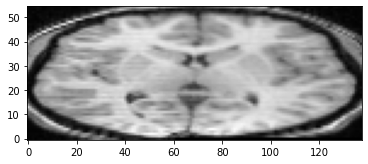

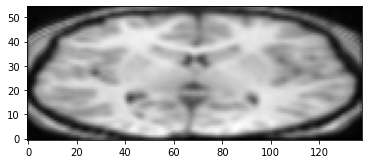

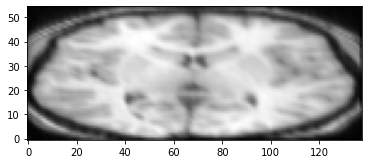

In [363]:
img5 = x_to_img(img3.shape[0], img3.shape[1], s_x)

img6 = x_to_img(img3.shape[0], img3.shape[1], s_g)

plt.imshow(img3.T, origin='lower', cmap='gray')
plt.show()

plt.imshow(img5.T, origin='lower', cmap='gray')
plt.show()

plt.imshow(img6.T, origin='lower', cmap='gray')
plt.show()

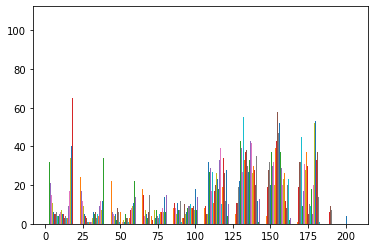

In [364]:
plt.hist(img3)
plt.show()

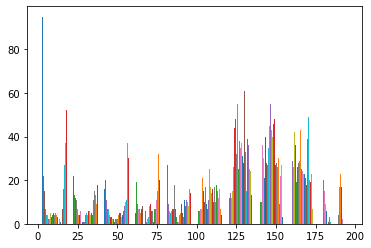

In [365]:
plt.hist(img5)
plt.show()

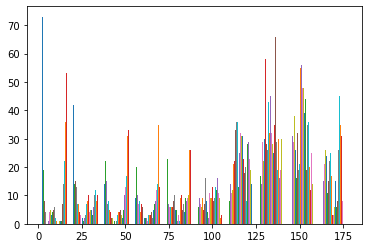

In [366]:
plt.hist(img6)
plt.show()